# Parameter containers.

Many models depend on several parameters of different types.  In this notebook, we demonstrate flattening and folding "containers", which are patterns containing other patterns.

## Parameter dictionaries.

In [1]:
import autograd
import autograd.numpy as np
import paragami
import example_utils
import inspect

import matplotlib.pyplot as plt
%matplotlib inline

Let's consider a multivariate normal example.  Define some parameters and draw some data.

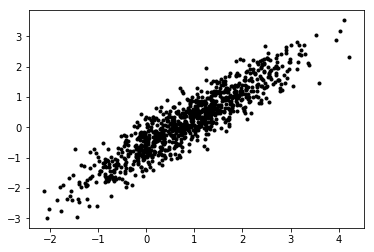

In [2]:
dim = 2
num_obs = 1000

mean_true = np.random.random(dim)
cov_true = np.random.random((dim, dim))
cov_true = 0.1 * np.eye(dim) + np.full((dim, dim), 1.0)

x = np.random.multivariate_normal(mean=mean_true, cov=cov_true, size=(num_obs, ))
plt.plot(x[:, 0], x[:, 1], 'k.')

A multivariate normal distribution depends on two parameters -- a mean and a positive definite covariance matrix. In Python, we might store these parameters in a dictionary with a member for the mean and a member for the covariance.  

This can be represented with a pattern dictionary, i.e., a ``paragami.PatternDict`` pattern.  Each member of a pattern dictionary must itself be a pattern.

In [3]:
mvn_pattern = paragami.PatternDict(free_default=True)
mvn_pattern['mean'] = paragami.NumericVectorPattern(length=dim)
mvn_pattern['cov'] = paragami.PSDSymmetricMatrixPattern(size=dim)

Flattening and folding work with pattern dictionaries just as with ordinary patterns.  Note that folded pattern dicitonaries are ``OrderedDict`` by default.

In [36]:
true_mvn_par = dict()
true_mvn_par['mean'] = mean_true
true_mvn_par['cov'] = cov_true

print('\nA dictionary of MVN parameters:\n{}'.format(
      true_mvn_par))

mvn_par_free = mvn_pattern.flatten(true_mvn_par)
print('\nA flat representation:\n{}'.format(
    mvn_pattern.flatten(true_mvn_par)))

print('\nFolding recovers the original parameters:\n{}'.format(
    mvn_pattern.fold(mvn_par_free)))


A dictionary of MVN parameters:
{'cov': array([[1.1, 1. ],
       [1. , 1.1]]), 'mean': array([0.87367236, 0.21280422])}

A flat representation:
[ 0.87367236  0.21280422  0.04765509  0.95346259 -0.82797896]

Folding recovers the original parameters:
OrderedDict([('mean', array([0.87367236, 0.21280422])), ('cov', array([[1.1, 1. ],
       [1. , 1.1]]))])


Parameter dictionaries are particularly convenient for optimization problems involving multiple parameters.  A good working style is to implement the loss function using named arguments and then wrap it using a lambda function.

To illustrate this, let us use ``get_normal_log_prob`` from ``example_utils``.

In [6]:
# ``example_utils.get_normal_log_prob`` returns the log probability of
# each datapoint x up to a constant.
def get_loss(x, sigma, mu):
    return -1 * np.sum(
        example_utils.get_normal_log_prob(x, sigma, mu))
       
get_free_loss = paragami.FlattenFunctionInput(
    lambda mvn_par: get_loss(x=x, sigma=mvn_par['cov'], mu=mvn_par['mean']),
    patterns=mvn_pattern,
    free=True)

print('Free loss:\t{}'.format(get_free_loss(mvn_par_free)))
print('Original loss:\t{}'.format(get_loss(x, true_mvn_par['cov'], true_mvn_par['mean'])))

Free loss:	219.8143711666299
Original loss:	219.8143711666299


As with other parameters, ``autograd`` works with parameter dictionaries.

In [7]:
get_free_loss_grad = autograd.grad(get_free_loss)
print(get_free_loss_grad(mvn_par_free))

[-59.66882221  78.5304     -24.49767189 -12.36127117  36.00719091]


### Pattern dictionaries containing pattern dictionaries.

Pattern dictionaries can contain pattern dictionaries (and so on).

In [34]:
mvns_pattern = paragami.PatternDict(free_default=True)
mvns_pattern['mvn1'] = mvn_pattern
mvns_pattern['mvn2'] = mvn_pattern
mvns_pattern['ez'] = paragami.SimplexArrayPattern(array_shape=(1, ), simplex_size=2)

mvns_par = dict()
mvns_par['mvn1'] = true_mvn_par
mvns_par['mvn2'] = mvn_pattern.random()
mvns_par['ez'] = np.array([[0.3, 0.7]])

print('Folded mvns_par:\n{}'.format(mvns_par))
print('\nFree mvns_par:\n{}'.format(mvns_pattern.flatten(mvns_par)))

Folded mvns_par:
{'mvn1': {'cov': array([[1.1, 1. ],
       [1. , 1.1]]), 'mean': array([0.87367236, 0.21280422])}, 'mvn2': OrderedDict([('mean', array([0.9666736 , 0.24848757])), ('cov', array([[4.77849291, 1.56784344],
       [1.56784344, 1.84355085]]))]), 'ez': array([[0.3, 0.7]])}

Free mvns_par:
[ 0.87367236  0.21280422  0.04765509  0.95346259 -0.82797896  0.9666736
  0.24848757  0.7820626   0.71722798  0.14226413  0.84729786]


Members of a pattern dictionary are just patterns, and can be used directly.

In [37]:
mvn_par_free = mvns_pattern['mvn1'].flatten(true_mvn_par)
print('\nA flat representation of true_mvn_par:\n{}'.format(
    mvn_pattern.flatten(true_mvn_par)))


A flat representation of true_mvn_par:
[ 0.87367236  0.21280422  0.04765509  0.95346259 -0.82797896]


### Locking parameter dictionaries.

The meaning of a parameter dictionary changes as you add or assign elements.

In [40]:
example_pattern = paragami.PatternDict(free_default=True)

example_pattern['par1'] = paragami.NumericVectorPattern(length=2)
print('The flat length of example_pattern with par1:\t\t\t{}'.format(
    example_pattern.flat_length()))

example_pattern['par2'] = paragami.NumericVectorPattern(length=3)
print('The flat length of example_pattern with par1 and par2:\t\t{}'.format(
    example_pattern.flat_length()))

example_pattern['par1'] = paragami.NumericVectorPattern(length=10)
print('The flat length of example_pattern with new par1 and par2:\t{}'.format(
    example_pattern.flat_length()))


The flat length of example_pattern with par1:			2
The flat length of example_pattern with par1 and par2:		5
The flat length of example_pattern with new par1 and par2:	13


Sometime, you want to make sure the meaning of a parameter dictionary stays fixed.  In order to prevent a pattern dictionary from having more elements added, you can ``lock()`` it.

In [43]:
example_pattern.lock()
try:
    example_pattern['par3'] = paragami.NumericVectorPattern(length=4)
except ValueError as err:
    print('Adding a new pattern failed with the following error:\n{}'.format(err))

try:
    example_pattern['par1'] = paragami.NumericVectorPattern(length=4)
except ValueError as err:
    print('\nChanging an existing pattern failed with the following error:\n{}'.format(err))

Adding a new pattern failed with the following error:
The dictionary is locked, and its values cannot be changed.

Changing an existing pattern failed with the following error:
The dictionary is locked, and its values cannot be changed.


## Parameter arrays.

Sometimes it is useful to have arrays of patterns.  A classic use case is mixture distributions.  Suppose that, for some $K$, and probabilities $pi_{k}$ for $k=1$ to $K$,

$$
\begin{align}
P(x_n | \pi, \mu_1,...,\mu_K, \Sigma_1,...,\Sigma_K) &= \sum_{k=1}^K \pi_{k} \mathcal{N}\left(x_n | \mu_k, \Sigma_k\right).
\end{align}
$$

Then the random variable $x_n$ is distributed according to a mixture of normals.  Let us define parameters and draw some data.

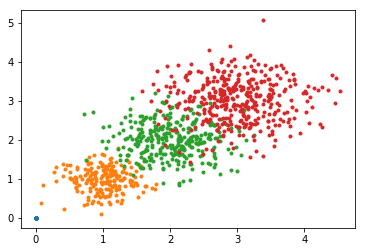

In [55]:
num_components = 4
pi_true = np.arange(1, num_components + 1)
pi_true = pi_true / np.sum(pi_true)

k_true = np.random.choice(range(num_components), p=pi_true, size=num_obs)

# Draw the regression coefficients.
true_means = np.array([
    np.full(dim, float(k)) for k in range(num_components) ])

true_covs = np.array([
    0.1 * k * np.eye(dim) for k in range(num_components) ])

# draw observations
y = np.array([
    np.random.multivariate_normal(
        true_means[k_true[n], :],
        true_covs[k_true[n], :, :]) for n in range(num_obs) ])

for k in range(num_components):
    k_rows = k_true == k
    plt.plot(y[k_rows, 0], y[k_rows, 1], '.')